# ASSIGMENT 1

In [3]:
import sympy as sp
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time
from astropy import constants as const

solar_system_ephemeris.set("jpl")
import matplotlib.pyplot as plt

from sympy.utilities.lambdify import lambdify
from scipy.integrate import odeint

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [4]:
from poliastro.bodies import Earth, Jupiter, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter

plt.style.use("seaborn")

earth = Orbit.from_body_ephem(Earth)
jupiter = Orbit.from_body_ephem(Jupiter)
sun = Orbit.from_body_ephem(Sun)

# frame = OrbitPlotter()
# frame.plot(earth, label="Earth")
# frame.plot(jupiter, label="Jupiter")

EPOCH = Time.now()
EPOCH = Time(EPOCH, scale='tdb')

earth =   Orbit.from_body_ephem(Earth, EPOCH)
jupiter = Orbit.from_body_ephem(Jupiter, EPOCH)
sun =     Orbit.from_body_ephem(Sun, EPOCH)

## 2D n-body problem

Set up symbols to be used for function to set up n-body problem

### Symbol space

In [5]:
r_i_x, r_i_y, r_j_x, r_j_y = sp.symbols('r_i_x, r_i_y, r_j_x, r_j_y', real=True)  # Positions
V_i_x, V_i_y, V_j_x, V_j_y = sp.symbols('V_i_x, V_i_y, V_j_x, V_j_y', real=True)  # Velocities

G = sp.symbols('G', real=True)

M, m_i, m_j = sp.symbols('M, m_i, m_j', real=True)

r_i_vec = sp.Matrix([r_i_x, r_i_y])
r_j_vec = sp.Matrix([r_j_x, r_j_y])
V_i_vec = sp.Matrix([V_i_x, V_i_y])
V_j_vec = sp.Matrix([V_j_x, V_j_y])
r_ij_vec = r_j_vec - r_i_vec

r_i_norm, r_j_norm, r_ij_norm = sp.symbols(['|r_i|', '|r_j|', '|r_ij|'])
r_i_sym, r_j_sym, r_ij_sym = sp.MatrixSymbol('r_i', 2, 1), sp.MatrixSymbol('r_j', 2, 1), sp.MatrixSymbol('r_ij', 2, 1)

### Equations of Motion: Barycentric form

In [6]:
"""
The following symbolic equations are those defining the n-body
problem with respect to the barcenter of the system. The following
are the respective outputs of the expressions using sympy.pprint().
It should be noted that the folowing samples are only between two
bodies.
"""

eom_bc1_vec = - G * M / (r_i_norm ** 3) * r_i_sym
eom_bc2_vec =   G * m_j * (1/ (r_ij_norm **3) - 1/(r_i_norm**3)) * r_ij_sym

"""
----------------------
Vector representation.
----------------------

>>> from sympy import pprint
>>> pprint(eom_bc1_vec + eom_bc2_vec)

-G⋅M             ⎛    1         1   ⎞     
──────⋅rᵢ +G⋅m_j⋅⎜- ────── + ───────⎟⋅r_ij
     3           ⎜       3         3⎟     
|r_i|            ⎝  |r_i|    |r_ij| ⎠     

"""

eom_bc1 = - G * M / (r_i_vec.norm() ** 3) * r_i_vec
eom_bc2 =   G * m_j * (1/ (r_ij_vec.norm() ** 3) - 1/(r_i_vec.norm() **3) ) * r_ij_vec

"""
------------------------
Component representation.
------------------------

>>> from sympy import pprint, latex
>>> print(latex(eom_bc1 + eom_bc2))

The image below shows the latex rendering of the above code output.
"""
pass

![alt text](component_representation.png "Component Representation")

Using the previous general definition for the barycentric EOM between i and j, we can now create a function to create the system of equations given any list of bodies. This is what `_barycentric_eom(bodies, vector=False)` is purposed for.

In [7]:
def _barycentric_eom(bodies, vector=False):
    """
    Returns the equations of motion for all bodies within the n-body barycentric reference frame.
    
    -G⋅M             ⎛    1         1   ⎞     
    ──────⋅rᵢ +G⋅m_j⋅⎜- ────── + ───────⎟⋅r_ij
         3           ⎜       3         3⎟     
    |r_i|            ⎝  |r_i|    |r_ij| ⎠   

    """
    _system = []
    if vector is False:
        for body_i in bodies:
            _body_system = []
            # Subscript symbol of body_i
            sub_i = body_i.name[0]
            
            # Parameter symbols of body_i
            var_i = {
                m_i: sp.symbols("m_{}".format(sub_i)),
                r_i_x: sp.symbols("r_{}_x".format(sub_i)),
                r_i_y: sp.symbols("r_{}_y".format(sub_i)),
            }
            
            # Add two-body influence from EOM
            _body_system.append(eom_bc1.subs(var_i))
            
            for body_j in bodies:
                
                # Ensure that body_j is not body_i, else skip.
                if body_j != body_i:
                
                    # Subscript symbol of body_j
                    sub_j = body_j.name[0]

                    # Parameter symbols of body_j
                    var_j = {
                        m_j: sp.symbols("m_{}".format(sub_j)),
                        r_j_x: sp.symbols("r_{}_x".format(sub_j)),
                        r_j_y: sp.symbols("r_{}_y".format(sub_j)),
                    }

                    # Add body_j perturbations from EOM
                    _body_system.append(eom_bc2.subs({**var_j, **var_i}))
                
                # Skip if body_j == body_i
                else: 
                    pass
                
            lhs = sp.Matrix([*sp.symbols(['a_{}_x'.format(sub_i), 'a_{}_y'.format(sub_i)])])
            rhs = sum(_body_system, sp.zeros(2,1))
            _system.append(sp.Eq(
                lhs[0], rhs[0]
            ))
            _system.append(sp.Eq(
                lhs[1], rhs[1]
            ))            
    return _system

"""
------------------------
Component representation.
------------------------

    >>> bodies = [Earth, Sun]
    >>> print(latex(_barycentric_eom(bodies)))

The image below shows the latex rendering of the above code output.
# TODO: Output format changed from below to sets of equations.
"""
pass



Sample output is seen below in vector format. The `sympy` allows for ease of LaTeX with its integrated formatter, from which the following render was created.

![alt text](component_test.png "Component Representation Test")

In [20]:
def _eq_linear_momentum(bodies):   # barycentre
    """
    returns Eq in vector format
    """
    _eq = []
    req = []
    for _body in bodies:
        sub_i = _body.name[0]
        _eq.append( (sp.symbols("m_{}".format(sub_i)) * 
                    sp.Matrix(sp.symbols("V_{}_x V_{}_y".format(sub_i, sub_i)))
                
                   ))
    shape = _eq[0].shape
    start = sp.zeros(*shape)
    m = sum(_eq, sp.zeros(*shape))
    return [sp.Eq(0, m[0]), sp.Eq(0, m[1])]

pprint(_eq_linear_momentum(bodies))

[0 = V_E_x⋅m_E + V_J_x⋅m_J + V_S_x⋅m_S, 0 = V_E_y⋅m_E + V_J_y⋅m_J + V_S_y⋅m_S]


In [9]:
def _eq_angular_momentum(bodies):  # 2D
    _eq = []
    for _body in bodies:
        _n = _body.name
        _eq.append(sp.symbols("m_{}".format(_n)) * 
                  (
                      sp.symbols("r_{}_x".format(_n)) * sp.symbols("V_{}_y".format(_n)) - sp.symbols("r_{}_y".format(_n)) * sp.symbols("V_{}_x".format(_n))
                  )
                  )
    return [sp.Eq(sp.symbols("H_z"), sum(_eq, 0))]

In [10]:
from mpmath import power

def _eq_energy_conservation(bodies, vector=False):
    """
    Returns the equation for the n-body system defining the total energy of the system.
    """
    _eq = []
    E_k = 0.5 * m_i * V_i_vec.norm() ** 2
    E_p = - 0.5 * G * (m_i * m_j) / r_ij_vec.norm()
    for i in bodies:
        sub_i=i.name[0]
        var_i={
            m_i:i.mass.si.value,
            r_i_x:sp.symbols('r_{}_x'.format(sub_i)),
            r_i_y:sp.symbols('r_{}_y'.format(sub_i)),
            V_i_x:sp.symbols('V_{}_x'.format(sub_i)),
            V_i_y:sp.symbols('V_{}_y'.format(sub_i))
        }
        _eq.append(E_k.subs(var_i))
        for j in bodies:
            if i != j:
                sub_j=j.name[0]
                var_j={
                    m_j:j.mass.si.value,
                    r_j_x:sp.symbols('r_{}_x'.format(sub_j)),
                    r_j_y:sp.symbols('r_{}_y'.format(sub_j)),
                    V_j_x:sp.symbols('V_{}_x'.format(sub_j)),
                    V_j_y:sp.symbols('V_{}_y'.format(sub_j))
                }
                _eq.append(E_p.subs({**var_i, **var_j}))
            else:
                pass
    return sp.Eq(sp.symbols("C"), sum(_eq, 0))


In [11]:
def _state_matrix(bodies):
    """
    Creates a symbolic vector of the state of the system given the bodies.
    """
    states = []
    for _body in bodies:
        sub_i = _body.name[0]
        for s in 'r_{}_x r_{}_y'.split(' '):

            states.append(sp.symbols(s.format(sub_i)))
    for _body in bodies:
        sub_i = _body.name[0]
        for s in 'V_{}_x V_{}_y'.split(' '):
        
            states.append(sp.symbols(s.format(sub_i)))
    return sp.Matrix(states)


def _derivative_matrix(bodies):
    """
    Create a symbolic vector for the state derivative of the system given the bodies.
    """
    states = []
    eom = _barycentric_eom(bodies)
    for _body in bodies:
        sub_i = _body.name[0]
        for s in 'V_{}_x V_{}_y'.split(' '):
            states.append(sp.symbols(s.format(sub_i)))
            
    for _body in bodies:
        sub_i = _body.name[0]
        for s in 'a_{}_x a_{}_y'.split(' '):
            states.append(sp.symbols(s.format(sub_i)))

    return sp.Matrix(states).subs([(eom[i].lhs, eom[i].rhs) for i in range(len(eom))])

In [12]:
def var(bodies):
    """
    Function built to return all constant parameters for a function 
    prior to a function being lambdified.
    """
    _var = {
        G: const.G.si.value,
        M: sum([b.mass.si.value for b in bodies])
    }
    for body in bodies:
        _sub_i = body.name[0]
        _var_b = {
            sp.symbols("m_{}".format(_sub_i)): body.mass.si.value,
        }
        _var = {**_var, **_var_b}
    return _var

In [13]:
def S0(bodies):
    """
    Returns the initial state vector given the list of involved bodies.
    It must be noted that the calculations below for Jupiter are only 
    valid when Jupiter is part of the input argument. Otherwise it is
    ignored in the calculation of the barcentre and velocity of bodies.
    
    Some important information:
    ===============================
    1) Imposed uncertainty      |||
    ===============================
    Name   = Gravitational constant
    Value  = 6.67408e-11
    Uncertainty  = 3.1e-15
    Unit  = m3 / (kg s2)
    Reference = CODATA 2014
    
    ===============================
    2) Parameters used          |||
    ===============================
    Jupiter -----------------------
    SMA: 5.2044 AU
    Earth -------------------------
    SMA: 1.0 AU    
    """
    # Step 1: Assume two-body problem positioning in arbitrary frame on x-axis.
    _a_Earth = u.AU.to(u.m)
    _a_Jupiter = u.AU.to(u.m)* 5.2044
    
    ## Initialised positions for bodies
    _pos_x = {
        Earth: _a_Earth,
        Jupiter: _a_Jupiter,
        Sun: 0.0}
    
    # Step 2: Calculate circular velocity using the SMA
    _V_circ_Earth = np.sqrt(Sun.k.si.value/_a_Earth)
    _V_circ_Jupiter = np.sqrt(Sun.k.si.value/_a_Jupiter)
    
    # Step 3: Calculate the position of the Barycentre in perifocal frame.
    _num = sum([b.mass.si.value * _pos_x[b] for b in bodies])
    _M = sum([b.mass.si.value for b in bodies])
    _r_cm_x =  _num/_M
    
    # Step 4: Offset x_position of bodies by r_cm
    for b in bodies:
        _pos_x[b] += - _r_cm_x
        
    # Step 5: Calculate velocity of Sun for sum of linear momentum = 0
    _st = {
        sp.symbols('r_E_x'):_pos_x[Earth],
        sp.symbols('r_E_y'):0.0,
        sp.symbols('r_S_x'):_pos_x[Sun],
        sp.symbols('r_S_y'): 0.0,
        sp.symbols('r_J_x'):_pos_x[Jupiter],
        sp.symbols('r_J_y'):0.0,
        sp.symbols('V_E_x'):0.0,
        sp.symbols('V_E_y'):_V_circ_Earth,
        sp.symbols('V_J_x'):0.0,
        sp.symbols('V_J_y'):_V_circ_Jupiter,
        sp.symbols('m_E'):Earth.mass.si.value,
        sp.symbols('m_J'):Jupiter.mass.si.value,
        sp.symbols('m_S'):Sun.mass.si.value
    }

    ## Solving the set of linear equations for the entire system's linear momentum.
    linear_momentum_eqs = [_eq.subs(_st) for _eq in _eq_linear_momentum(bodies)]
    
    sol = sp.solve(linear_momentum_eqs, dict=True)
    _st[sp.symbols("V_S_x")] = sol[0][sp.symbols('V_S_x')]
    _st[sp.symbols("V_S_y")] = sol[0][sp.symbols('V_S_y')]

    ## Generate state vector depending on given bodies.
    _state = [_st[_s] for _s in np.array(S).flatten()]
    
    # Step 6: Return the state vector!
    return np.array(_state).flatten().astype(float)



## Prepare for propagation (Earth + Sun)

In [14]:
# Define bodies for n-body system.
bodies = [Earth, Sun]

# Instantiate state-vector from bodies list.
S = _state_matrix(bodies=bodies)

# Instantiate state-vector derivative from bodies list.
F = _derivative_matrix(bodies)

# Energy equation for evaluation.
E = _eq_energy_conservation(bodies).subs(var(bodies))

# Lambdify for increased computation of energy.
E = lambdify((S), (E.rhs))

# Substitute constants to increase speed through propagation.
F = F.subs(var(bodies))

## Prepare for propagation (Earth + Sun + Jupiter)

In [15]:
# Define bodies for n-body system.
bodies = [Earth, Sun, Jupiter]

# Instantiate state-vector from bodies list.
S = _state_matrix(bodies=bodies)

# Instantiate state-vector derivative from bodies list.
F = _derivative_matrix(bodies)

# Energy equation for evaluation.
E = _eq_energy_conservation(bodies).subs(var(bodies))

# Lambdify for increased computation of energy.
E = lambdify((S), (E.rhs))

# Substitute constants to increase speed through propagation.
F = F.subs(var(bodies))

bodies = [Earth, Sun, Jupiter]
from sympy import pprint, latex
print(latex(sp.Matrix(S0(bodies))))

\left[\begin{matrix}148854763525.635\\0.0\\-743107174.364845\\0.0\\777824051096.715\\0.0\\0.0\\29784.6920652165\\0.0\\-12.5551530705683\\0.0\\13055.9290198896\end{matrix}\right]


In [16]:
# Lambdify the symbolic expression for increased computational speed.
"""
The Lambdified equation for dS is used in the following way, and returns accordingly.
    
    >>> dS(*S)
    
    ::returns::
    [V_Earth_x V_Earth_y V_Sun_x V_Sun_y a_Earth_x a_Earth_y a_Sun_x a_Sun_y]
    
    ::type:: np.ndarray
    
"""
dS = lambdify((S), (F))

# Define function for the propagation procedure.
def dS_dt(_S, t):
    """
    Integration of the governing vector differential equation for
    the barcyentric form of the two-body problem.
    
    [example]
    S = [r_Earth_x r_Earth_y r_Sun_x r_Sun_y V_Earth_x V_Earth_y V_Sun_x V_Sun_y]
    F = [V_Earth_x V_Earth_y V_Sun_x V_Sun_y a_Earth_x a_Earth_y a_Sun_x a_Sun_y]

    """
    return np.array(dS(*_S)).flatten().astype(float)

In [17]:
# Define the time-steps for the propagation.
t = np.arange(0.0, 365*24*60*60, 100)

# Calculate the results from the propagation.
S_l = odeint(dS_dt, S0(bodies), t) 

"""
The following plot is for the energy throughout the time domain.
    - Setting the time-step to 0.0000001 for np.arange(0, 0.00001) 
        shows that the jump in energy is not a result of integration error, 
        but implementation error.
"""
# Plot graph of Energy throughout time domain of entire system.
# figure(figsize=(6,4), dpi=300, facecolor='w', edgecolor='k')
# plt.plot(t, [E(*S_l[i,:]) for i in range(len(t))])  
# plt.axes().set_xlabel('t [s]')
# plt.axes().set_ylabel('C [J]')
# ax = plt.gca()
# ax.ticklabel_format(useOffset=False)
# plt.show()

# figure(figsize=(7,4), dpi=300, facecolor='w', edgecolor='k')
# plt.axes().set_aspect('equal')
# plt.axes().set_xlabel('x [m]')
# plt.axes().set_ylabel('y [m]')
# for idx, body in enumerate(bodies):
#     plt.plot(S_l[:,idx*2], S_l[:,idx*2+1], label=body.name)
# plt.show()

"""
Velocity plots for Earth and Sun respectively.
"""
# plt.plot(S_l[:,4], S_l[:,5])
# plt.plot(S_l[:,6], S_l[:,7])
# plt.show()
pass
    

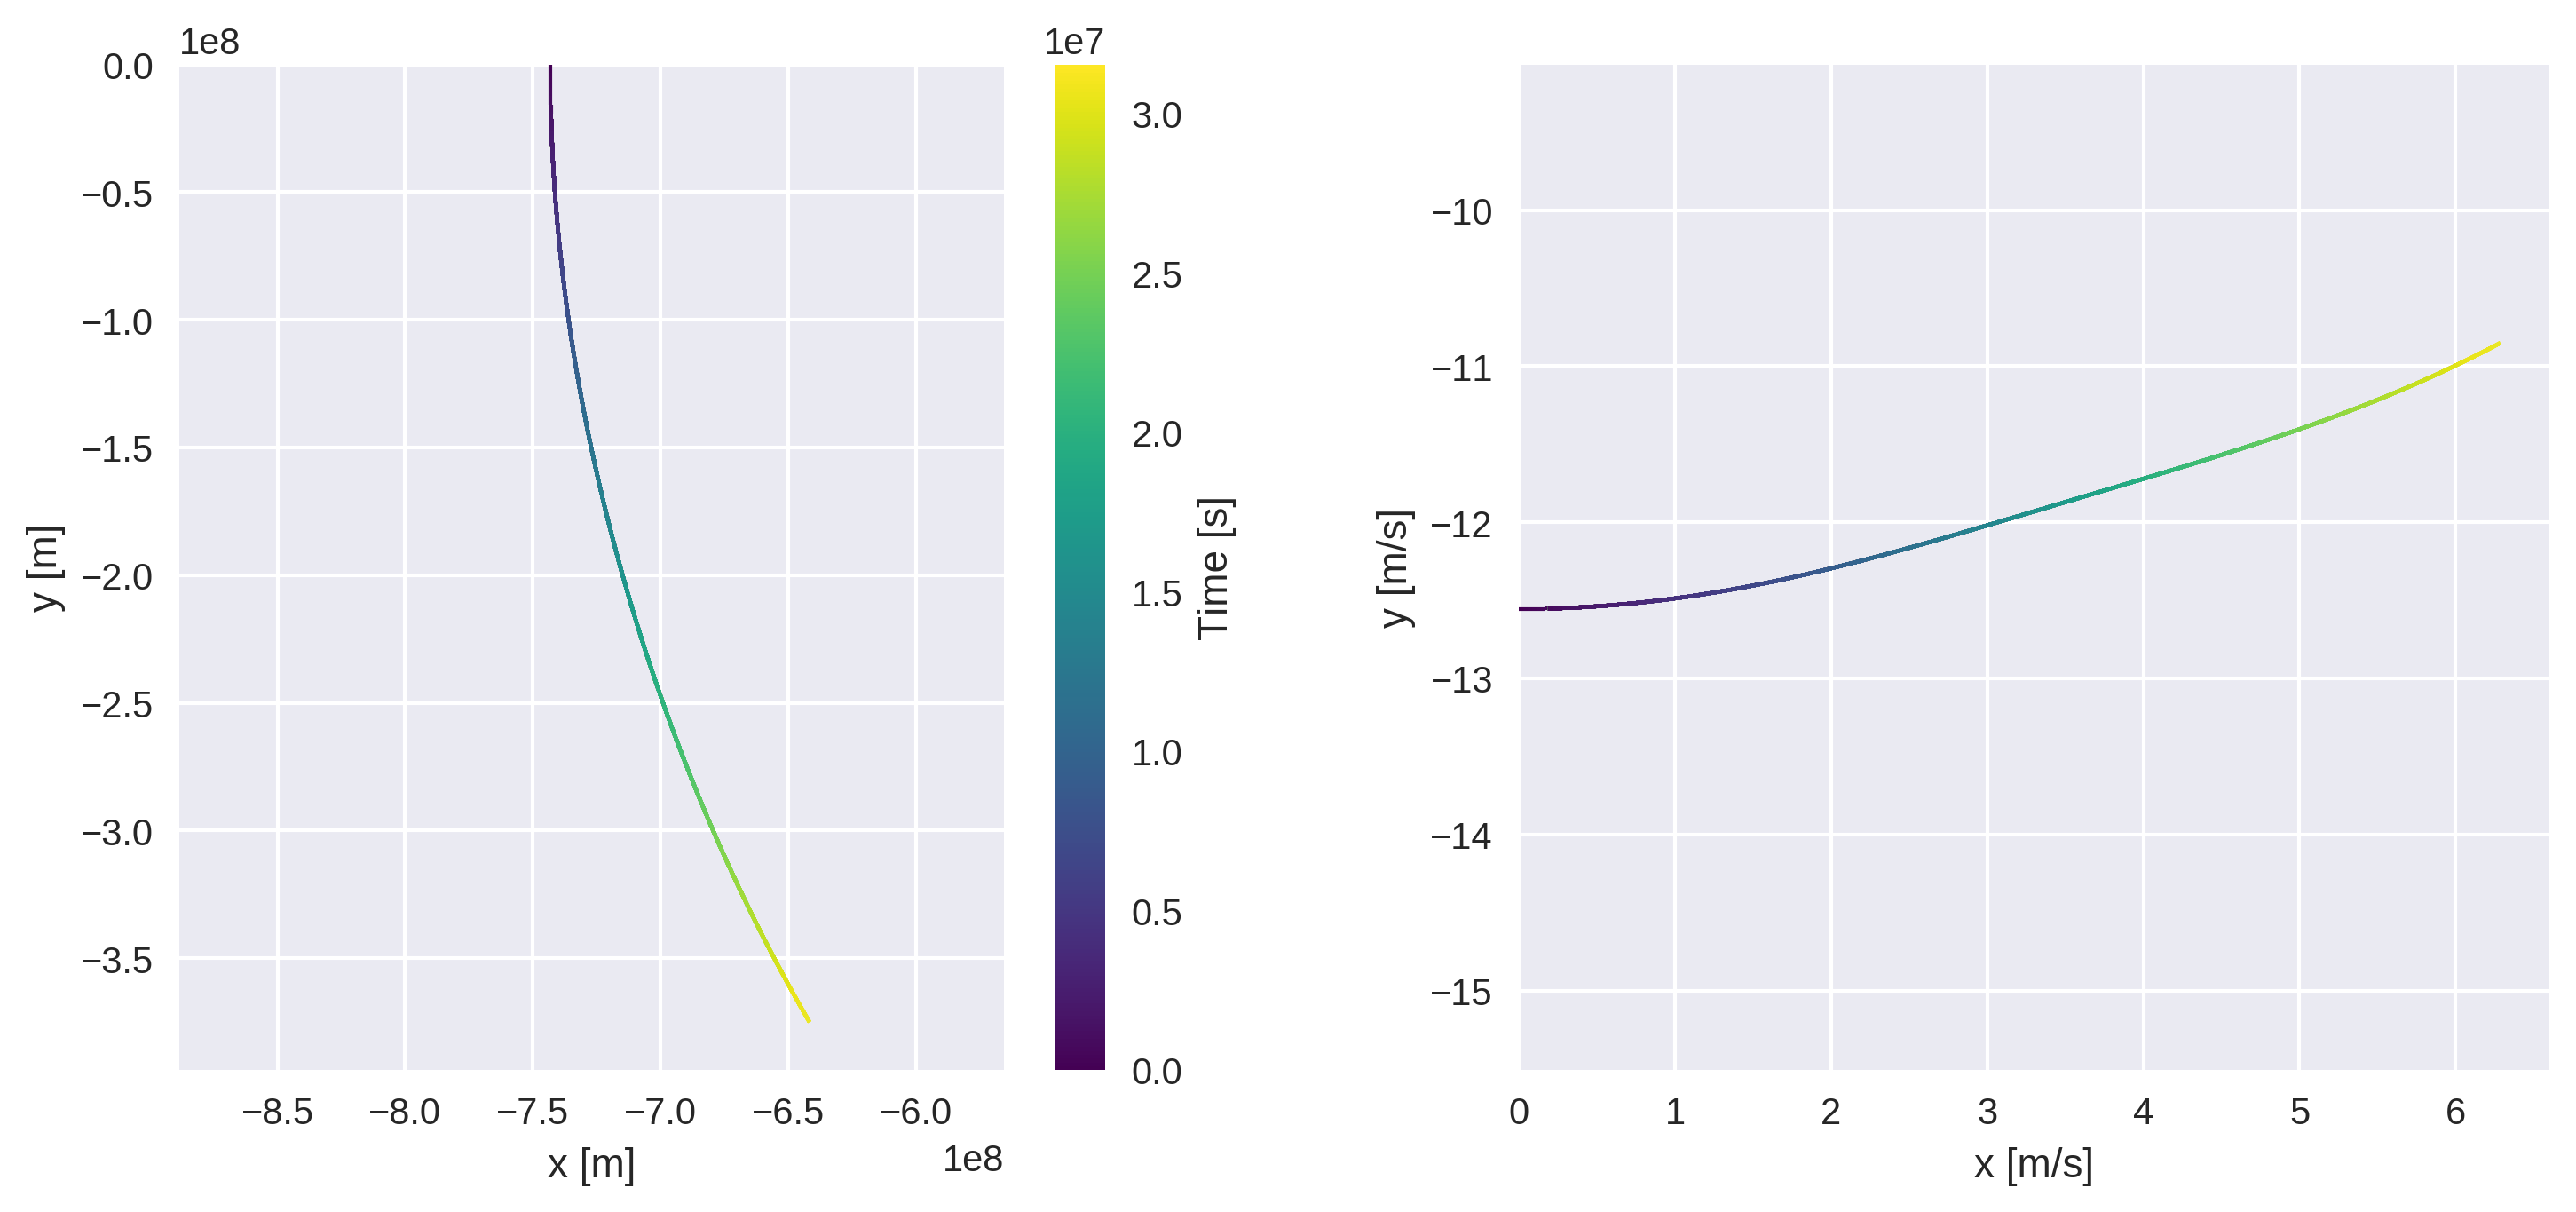

In [18]:
x = S_l[:,2]
y = S_l[:,3]
dx = S_l[:,8]
dy = S_l[:,9]
dydx = t

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

points2 = np.array([dx, dy]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300, facecolor='w', edgecolor='k')

axs[0].set_aspect('equal', 'datalim')
axs[0].set_xlim(np.min(x)*1.05, np.max(x)*1.05)
axs[0].set_ylim(np.min(y)*1.05, np.max(y)*1.05)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(dydx)
lc.set_linewidth(1)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0], label='Time [s]')
axs[0].set_ylabel('y [m]')
axs[0].set_xlabel('x [m]')

axs[1].set_aspect('equal', 'datalim')
axs[1].set_xlim(np.min(dx)*1.05, np.max(dx)*1.05)
axs[1].set_ylim(np.min(dy)*1.05, np.max(dy)*1.05)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments2, cmap='viridis', norm=norm)
lc.set_array(dydx)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)
# fig.colorbar(line, ax=axs[0], label='Time [s]')
plt.subplots_adjust(left=0.01,wspace=0.30)

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for space between subplots,
#                # expressed as a fraction of the average axis width
# hspace = 0.2   # the amount of height reserved for space between subplots,
#                # expressed as a fraction of the average axis height
    
axs[1].set_ylabel('y [m/s]')
axs[1].set_xlabel('x [m/s]')

plt.show()